In [1]:
import os
os.chdir("/Users/liutianlin/Desktop/Academics/MINDS/neuromorphic") # the root folder of dynapseReservoir and DYNAPSETools

import numpy as np
import matplotlib.pyplot as plt


from dynapseReservoir.networks.inputsParameters import in_5_0_P
from dynapseReservoir.networks.reservoirsParameters import generalNetP 
import DYNAPSETools.dynapseSpikesGenerator as DSG




# Book keeping the neuron positions

In [2]:
np.random.seed(in_5_0_P["seed"])

plt.close("all")

#======================  Create events
# The trigger event that marks the start of the experiment
startTrigger = DSG.InputPattern(name = "startTrigger", isiBase = in_5_0_P["isiBase"])
U, C, N = generalNetP["inStartTriggerPos"]   
# In this case, U4C0N16, the source address in the .txt file should be 1039. This is because N16 => 10000, C0 =>00, U04 => 1111 , 
# and the decimal of 10000001111 is 1039.


startTrigger.single_event(virtualSourceCoreId = C,
                          neuronAddress = N,
                          coreDest = in_5_0_P["coreDest"], # (= 15, means to all cores 0,1,2,3)
                         firePeriod = in_5_0_P["startDelay"])  



# First classification
onesClassification = DSG.InputPattern(name = "onesClassification", isiBase = in_5_0_P["isiBase"])
U, C, N = generalNetP["inTargetEncodingPos"]
onesClassification.single_event(virtualSourceCoreId = C,
                                neuronAddress = N,
                                coreDest = in_5_0_P["coreDest"],
                                firePeriod = in_5_0_P["safeDelay"])

# In this case, U4C0N1, the source address in the .txt file should be 79. This is because N1 => 1, C0 =>00, U04 => 1111 , 
# and the decimal of 1001111 is 79.

In [3]:

# Out neuron 2 classification
twoClassification = DSG.InputPattern(name = "twoClassification", isiBase = in_5_0_P["isiBase"])
N = N + 1
twoClassification.single_event(virtualSourceCoreId = C,
                                neuronAddress = N,
                                coreDest = in_5_0_P["coreDest"],
                                firePeriod = in_5_0_P["safeDelay"])


# The end of stimulus
endStimulus = DSG.InputPattern(name = "endStimulus", isiBase = in_5_0_P["isiBase"])
U, C, N = generalNetP["inEndStimulusPos"]
endStimulus.single_event(virtualSourceCoreId = C,
                         neuronAddress = N,
                         coreDest = in_5_0_P["coreDest"],
                         firePeriod = in_5_0_P["safeDelay"])

# The end of the experiment
stopTrigger = DSG.InputPattern(name = "stopTrigger", isiBase = in_5_0_P["isiBase"])
U, C, N = generalNetP["inStopTriggerPos"]
stopTrigger.single_event(virtualSourceCoreId = C,
                         neuronAddress = N,
                         coreDest = in_5_0_P["coreDest"],
                         firePeriod = in_5_0_P["stopDelay"])


# Creating input pattern: (1) RAMP+SINE and (2) SINE

### The First Pattern: SINE + RAMP


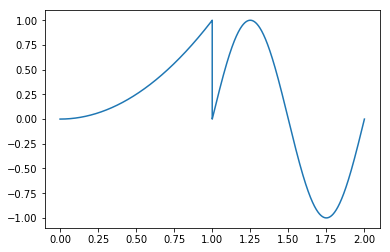

In [4]:
signal1 = DSG.InputPattern(name = "signal1", isiBase = in_5_0_P["isiBase"])

# Create the RAMP part which lasts for 1 second
tStart = tStop = 0
tStop += in_5_0_P["sig1part2Duration"]
tSig1Part2 = np.linspace(tStart, tStop, int(in_5_0_P["sigSamples"]))
ySig1Part2 = np.square(tSig1Part2 - tStart)


# Create the SINE signal part which lasts for 1 second
tStart = tStop
tStop += in_5_0_P["sig1part3Duration"]
tSig1Part3 = np.linspace(tStart, tStop, int(in_5_0_P["sigSamples"]))
ySig1Part3 = np.sin(2 * np.pi * in_5_0_P["sig1part3Freq"] * (tSig1Part3 - tStart))

# combine the ramp and the sine

tSig1 = np.ndarray.flatten(np.array([tSig1Part2, tSig1Part3]))
ySig1 = np.ndarray.flatten(np.array([ySig1Part2, ySig1Part3]))



plt.plot(tSig1, ySig1)


In [8]:

U, C, N1 = generalNetP["inCH0"]
U, C, N2 = generalNetP["inCH1"]
signal1.threshold_encoder(virtualSourceCoreId = C,
                          neuronAddressUpCH = N1,  
                          neuronAddressDwCH = N2,  
                          coreDest = in_5_0_P["coreDest"],   
                          threshold = in_5_0_P["sigThd"],    
                          t = tSig1,    
                          y = ySig1,    
                          noiseVar = in_5_0_P["sig1Jitter"],      
                          initDelay = in_5_0_P["sig1Delay"])  

### The Second Pattern:  RAMP


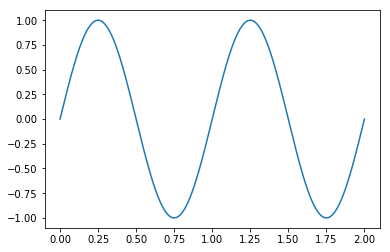

In [9]:
signal2 = DSG.InputPattern(name = "signal2", isiBase = in_5_0_P["isiBase"])
tSig2 = np.linspace(0, in_5_0_P["sig2Duration"], int(in_5_0_P["sigSamples"]))
ySig2 = np.sin(2 * np.pi * in_5_0_P["sig2Freq"] * tSig2)

U, C, N1 = generalNetP["inCH0"]
U, C, N2 = generalNetP["inCH1"]
signal2.threshold_encoder(virtualSourceCoreId = C,
                          neuronAddressUpCH = N1,
                          neuronAddressDwCH = N2,
                          coreDest = in_5_0_P["coreDest"],
                          threshold = in_5_0_P["sigThd"],
                          t = tSig2,
                          y = ySig2,
                          noiseVar = in_5_0_P["sig2Jitter"],
                          initDelay = in_5_0_P["sig2Delay"])

plt.plot(tSig2, ySig2)


# Create Final Patterns

In [10]:
#======================  Create Final Patterns
finalPattern = []


# repeat the RAMP + SINE signal twice as a washout
washoutPattern1 = signal1
for i in np.arange(2):
    finalPattern.append(washoutPattern1)
    
recordPattern1 = (startTrigger,
                 onesClassification,
                 signal1,
                 endStimulus,
                 stopTrigger)


# repeat the  RAMP + SINE signal 3 times (will use this part for the classification)
for i in np.arange(3):
    finalPattern.extend(recordPattern1)

    
# repeat the SINE signal twice as a washout

washoutPattern2 = signal2

for i in np.arange(2):
    finalPattern.append(washoutPattern2)
    
recordPattern2 = (startTrigger,
                 twoClassification,
                 signal2,
                 endStimulus,
                 stopTrigger)

# repeat the  SINE signal 3 times (will use this part for the classification)
for i in np.arange(3):
    finalPattern.extend(recordPattern2)
    
    


In [ ]:
2

# Save and plot

In [11]:
fileName = "/Users/liutianlin/Desktop/Academics/MINDS/neuromorphic/caer/myStimulus/correct_inClassification.txt"
DSG.write_to_file(*finalPattern, fileName = fileName)

Checking and writing pattern signal1
Current pattern lenght is 62
Cumulative pattern lenght is 62. Remaining 32705 events
Pattern signal1 succesfully written

Checking and writing pattern signal1
Current pattern lenght is 62
Cumulative pattern lenght is 124. Remaining 32643 events
Pattern signal1 succesfully written

Checking and writing pattern startTrigger
Current pattern lenght is 1
Cumulative pattern lenght is 125. Remaining 32642 events
Pattern startTrigger succesfully written

Checking and writing pattern onesClassification
Current pattern lenght is 1
Cumulative pattern lenght is 126. Remaining 32641 events
Pattern onesClassification succesfully written

Checking and writing pattern signal1
Current pattern lenght is 62
Cumulative pattern lenght is 188. Remaining 32579 events
Pattern signal1 succesfully written

Checking and writing pattern endStimulus
Current pattern lenght is 1
Cumulative pattern lenght is 189. Remaining 32578 events
Pattern endStimulus succesfully written

Chec

(<Figure size 432x288 with 1 Axes>,
  [<matplotlib.lines.Line2D at 0x1327e1ef0>]])

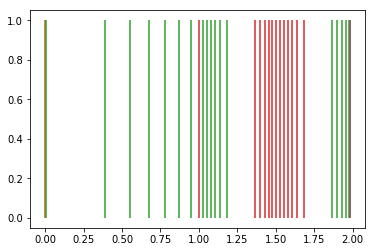

In [11]:
inputPatternList = recordPattern1
sumPattern1 = InputPattern(name = "sumPattern1", isiBase = inputPatternList[0].isiBase)

for pattern in inputPatternList:
    sumPattern1.eventList = np.append(sumPattern1.eventList, pattern.eventList)

for event in sumPattern1.eventList:
    event.time = event.time/10**6
    
sumPattern1.plot_spikes()

(<Figure size 432x288 with 1 Axes>,
  [<matplotlib.lines.Line2D at 0x1328ba278>]])

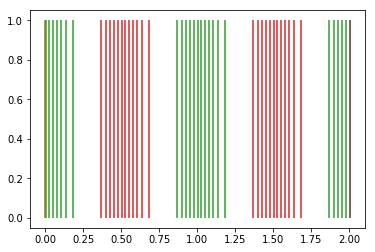

In [12]:
inputPatternList = recordPattern2
sumPattern2 = InputPattern(name = "sumPattern2", isiBase = inputPatternList[0].isiBase)

for pattern in inputPatternList:
    sumPattern2.eventList = np.append(sumPattern2.eventList, pattern.eventList)

for event in sumPattern2.eventList:
    event.time = event.time/10**6
    
sumPattern2.plot_spikes()    
    

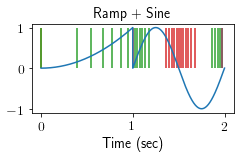

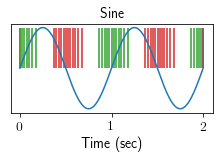

In [56]:
# fig, ax1, handles = sumPattern1.plot_spikes()

plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=14)
plt.rc('axes', titlesize=14)     # fontsize of the axes title
plt.rc('ytick', labelsize=14)
plt.rc('axes', labelsize=14)

# plt.rcParams.update({'font.size': 22})
width = 6.37 / 2
height = width / 1.618 


# fig = plt.figure()

# ax1 = fig.add_subplot(121)
# _, ax1, _ = sumPattern1.plot_spikes()
# ax1.plot(tSig1, ySig1)

fig, _, _ = sumPattern1.plot_spikes()
plt.plot(tSig1, ySig1)
plt.title('Ramp + Sine')
plt.xlabel('Time (sec)')



fig.subplots_adjust(left=.1, right=.98, top=.88, bottom = 0.25, wspace=0.2)

fig.set_size_inches(width, height)

plt.gcf().savefig('/Users/liutianlin/Desktop/Academics/MSc_thesis/my_msc_thesis/figs/thesis_sine_ramp1.pdf', dpi=1200)


fig, _, _ = sumPattern2.plot_spikes()
plt.plot(tSig2, ySig2)
plt.title('Sine')
plt.xlabel('Time (sec)')
plt.yticks([])

fig.subplots_adjust(left=.1, right=.98, top=.88, bottom = 0.25, wspace=0.2)

fig.set_size_inches(width, height)

plt.gcf().savefig('/Users/liutianlin/Desktop/Academics/MSc_thesis/my_msc_thesis/figs/thesis_sine_ramp2.pdf', dpi=1200)
plt.show()


In [100]:
# import matplotlib.pyplot as plot
# plot.eventplot(recordPattern1[2].tSig, lineoffsets = 0, linelengths = 6.27, linewidths = 0.4, color = 'k')     




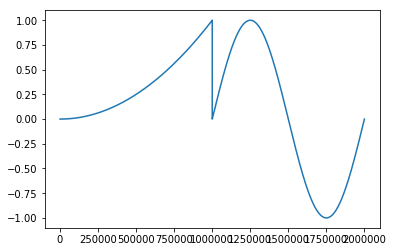

In [30]:
# ====================== Write events to output file in cAER folder
# fileName = "/Users/liutianlin/Desktop/Academics/MINDS/neuromorphic/caer/myStimulus/inClassification.txt"
# DSG.write_to_file(*finalPattern, fileName = fileName)



fig, ax1, handles = DSG.plot_spikes(recordPattern1[2])
delay = in_5_0_P["startDelay"] + in_5_0_P["safeDelay"] + in_5_0_P["sig1Delay"]
handle = ax1.plot((np.linspace(0, in_5_0_P["sig2Duration"], 2*int(in_5_0_P["sigSamples"])) + delay)*1e6, np.array(list(ySig1)))
# handle = ax1.plot((np.linspace(0, in_5_0_P["sig2Duration"], 2*int(in_5_0_P["sigSamples"])) + delay), np.array(list(ySig1)))



In [18]:
delay

NameError: name 'delay' is not defined

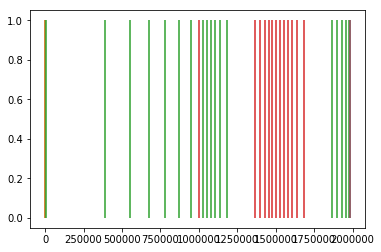

In [35]:
fig, ax, handles = DSG.plot_spikes(*recordPattern1)


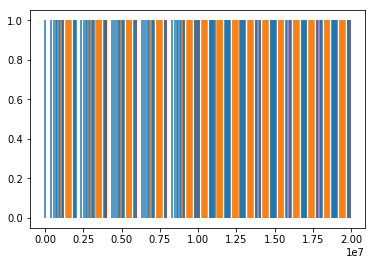

In [36]:
fig, ax, handles = DSG.plot_spikes(*finalPattern)


In [33]:
finalPattern